# Création d'une carte à partir des données renseignées de la burette

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import geocoder
import geopandas as gp
import pyproj
from shapely.geometry import Point, Polygon, LineString
import geopandas as gpd

wgs84 =  pyproj.Proj('+init=EPSG:4326')
lambert = pyproj.Proj('+init=EPSG:2154')

%matplotlib inline

def get_gps(a):
    """
    Récuparation des coordonnées sur OSM à partir d'une adresse
    """
    if pd.isnull(a):
        return None
    g = geocoder.osm(a)
    try:
        gps =  (g.geojson["features"][0]["properties"]["lat"],g.geojson["features"][0]["properties"]["lng"])
    except:
        print(a,"not found")
        gps = None
    return gps

/Users/emilien/anaconda3/envs/p37/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/Users/emilien/anaconda3/envs/p37/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


## Étape 1 : récupération des données sur la burrettes

Il faut télécharger à partir de la burette une liste des adhésions récentes (sur une année). Il faut trouver le champ qui correspond à la date. Dans le cas ici, c'est sur l'onglet adhésion puis le champ Partenaire > Adresse

In [6]:
# Chargement des données
data = pd.read_csv("membership.membership_line.csv")
data

,External ID,Partenaire/Nom,Partenaire/Adresse complète,Partenaire/Date de Début d'Adhésion,Partenaire/Date de fin d'adhésion,Date d'adhésion
0,__export__.membership_membership_line_16279,CHUBBI Berileina,France,2021-02-13,2022-02-12,2021-02-13
1,__export__.membership_membership_line_16278,BOUBENNA Saada,141 Boulevard Baille 13005 MARSEILLE France,2020-01-22,2022-02-12,2021-02-13
2,__export__.membership_membership_line_16277,MORTALI Deborah,Marseille France,2021-02-13,2022-02-12,2021-02-13
3,__export__.membership_membership_line_16276,VILELA Claudia,Marseille France,2021-02-13,2022-02-12,2021-02-13
4,__export__.membership_membership_line_16275,MENDEZ Youna,Marseille France,2021-02-13,2022-02-12,2021-02-13
...,...,...,...,...,...,...
1995,__export__.membership_membership_line_14187,FRONCZAK Kasia,58 Cours Gouffé 13006 France,2019-05-16,2020-05-15,2019-05-16
1996,__export__.membership_membership_line_14186,GRILLET Benjamin,11 rue Manière 13004 Marseille France,2019-05-16,2020-05-15,2019-05-16
1997,__export__.membership_membership_line_14185,GENY Lison,6 rue Fontange 13006 Marseille France,2019-05-15,2020-05-14,2019-05-15
1998,__export__.membership_membership_line_14184,DU CHAYLA Marin,61 rue alphonse daudet 13013 marseille France,2019-05-15,2020-05-14,2019-05-15


Filtrage à tous les adhérents qui ont pris une adhésion en 2020 !

In [23]:
data["Date d\'adhésion"] = pd.to_datetime(data["Date d\'adhésion"])
data = data[(data["Date d\'adhésion"]>="2020-01-01") & (data["Date d\'adhésion"]<"2021-01-01")]
len(data)

1201

## Étape 2 géocodage

On utilise le service https://adresse.data.gouv.fr/csv avec un fichier mis en forme

In [24]:
data["Partenaire/Adresse complète"].to_csv("adresses-geocodage.csv")

On charge le fichier géocodé

In [25]:
adresses = pd.read_csv("adresses-geocodage.geocoded.csv")

Il y a des adresses non renseignées. Adresses localisées à Marseille :

In [29]:
(adresses["result_city"]=="Marseille").value_counts()

True     838
False    363
Name: result_city, dtype: int64

On se restreint au adresses validées, et on enlève aussi les adresses qui n'ont pas été localisées en dessous de l'échelle de la ville (une étude est faite pour valider les problèmes)

- ceux qui ont mis juste "Marseille"
- ceux dont l'adresse n'est pas géocodée

In [34]:
adresses = adresses[(adresses["result_city"]=="Marseille") & (adresses["result_type"]!="municipality")]

Enlever les allocations de "Marseille France"


In [60]:
adresses = adresses[adresses["result_name"]!="Impasse Jeune France"] #Après analyse des données

Au final, il y a comme adresses effectivements géocodées

In [61]:
len(adresses)

706

Transformation des données en tableau GéoPandas

In [62]:
adresses["geometry"] = adresses.apply(lambda x : Point(x["longitude"],x["latitude"]),axis=1)
adresses = gpd.GeoDataFrame(adresses,geometry="geometry")

## Étape 3 : Cartographie

Chargement de la carte (carte nationale ensuite filtrée pour n'avoir que Marseille + ajout des données INSEE pour la densité de population)

In [63]:
france = gpd.read_file("../Ressources/Cartes/CONTOURS-IRIS_2-1_SHP_LAMB93_FXX-2017/CONTOURS-IRIS.shp")
france["Marseille"] = france.apply(lambda x : 1 if "Marseille" in x["NOM_COM"] and x["INSEE_COM"][0:2]=="13" else 0,axis=1)
population = pd.read_excel("../Ressources/INSEE/base-ic-evol-struct-pop-2015.xls",skiprows=5)
population = population.set_index("IRIS")
france = france.join(population, on="CODE_IRIS",rsuffix="add")
marseille = france[france["Marseille"]==1]

Changement de référentiel des données d'adresses (de GPS en lambert)

In [ ]:
adresses.crs = {'init':'epsg:4326'}
adresses = adresses.to_crs(epsg="2154")

Attribution de chaque adresse à un IRIS

In [75]:
marseille["pop_iris"] = marseille.apply(lambda x: adresses.within(x["geometry"]).sum(),axis=1)

Construction de la carte

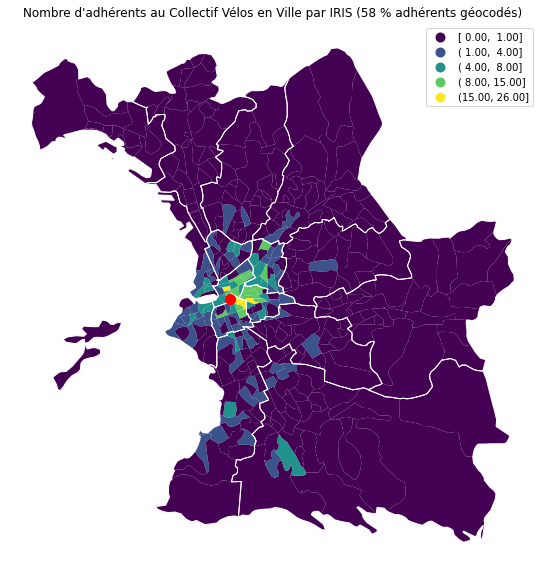

In [77]:
#Tracer la carte
ax = marseille.plot(figsize=(10,10),column="pop_iris",legend=True,scheme="fisher_jenks")

# Faire apparaître les arrondissements
marseille.dissolve(by="INSEE_COM").plot(ax=ax,facecolor="none",edgecolor="white")

# Mettre le CVV
plt.scatter(893284.4917758226, 6246795.348465629,s=100,color="red")

# Paramètres
ax.set_axis_off()
plt.title("Nombre d'adhérents au Collectif Vélos en Ville par IRIS (%d %% adhérents géocodés)"%round(100*len(adresses)/len(data),1))

#plt.scatter(x=[i[0] for i in list(adresses)],y=[i[1] for i in list(adresses)],s=5,alpha=0.1,color="red")
plt.savefig("Adhérents-CVV-2020-IRIS.png",dpi=300)
